In [9]:
import numpy as np
import pandas as pd
import os
from load_testdata import read_poly_coefficients, read_profile_pepsi, load_xyz, read_sasbdb
from debyecalc_Iq import DebyeCalculator
from formfactor import cSAXSparameters
from collections import defaultdict
import glob
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import voronotalt as voro

In [10]:
poly_coeffs = read_poly_coefficients('../poly_atomic.csv')

#poly = poly_coeffs[poly_coeffs[:,0]=='H2O',2]
#print(poly)

def getfitted_ff(aa, q, polyA):
    """ Get the fitted form factor for a given amino acid
        q is the scattering vector
    Args:
        aa (str): Amino acid
        q (np.array): scattering vector
    returns:
        f (np.array): fitted form factor
    """
    result = np.zeros(len(q))
    poly = polyA[polyA[:,0]==aa,2]
    result = poly[0]+poly[1]*q+poly[2]*q**2+poly[3]*q**3+poly[4]*q**4+poly[5]*q**5+poly[6]*q**6
    return result


qrange = np.linspace(0, 0.5, 101)
xyz_file = "../cg_structures/ala.xyz"

AA = pd.read_csv(xyz_file)
print(AA)
amino_acid = np.array(['ALA'])
coordinates = np.array([12.5064, 7.9314, 4.5896])
print(coordinates)
atFF = np.array([getfitted_ff(amino_acid, qrange, poly_coeffs)])
print(atFF[0,0]) 



                           1
0  ALA 12.5064 7.9314 4.5896
[12.5064  7.9314  4.5896]
37.99362301706037


In [ ]:
# Create Voronoi ball


balls = []
    
balls.append(voro.Ball(coordinates[0], coordinates[1], coordinates[2], 3.1))

# rt = voro.RadicalTessellation(balls, probe=1.4)

# cells=list(rt.cells)

# print("cells:")

# for i, cell in enumerate(cells):
#     print("cell", i, cell.sas_area, cell.volume)

max_volume = 4/3*np.pi*(3.1+1.4)**3
min_volume = 4/3*np.pi*(3.1)**3
print("Volume:", max_volume, min_volume)




Volume: 381.7035074111598 124.78824899079137


In [18]:
def getDummyAtomsFactorCorr0( q, V):
        """
        Calculate the correction factor for dummy atoms contribution to the form factor.
        This method computes the correction factor for the excluded solvent contribution 
        of dummy atoms according to the Pepsi-SAXS model (version nr1). Unlike version nr0, 
        this implementation uses the tabulated volume of the dummy atom.
        Args:
            q (float): The scattering vector magnitude.
            V (object): An object representing the dummy atom, containing its tabulated 
                        volume (`dsv`) and other properties.
        Returns:
            float: The correction factor for the dummy atoms contribution to the form factor.
        Notes:
            - The correction factor is calculated using the formula:
              `p * V * exp(-s2 * π * (V^(2/3)))`
              where:
              - `p` is a the mean electron density of the solvent (0.334),
              - `V` is the tabulated volume of the dummy atom,
              - `s2` is derived from the scattering vector magnitude `q`.
        """ 
        
        p = 0.334 # mean electron density of the solvent
        s2 = q * q / (4 * np.pi * np.pi)
        factor = s2 * np.pi * pow(V, 2.0 / 3.0)
        return p * V * np.exp(-factor)

In [20]:
FFq = np.array([getDummyAtomsFactorCorr0(q, max_volume) for q in qrange])
print(FFq)

[127.48897148 127.4756261  127.43559835 127.36891337 127.27561302
 127.15575584 127.00941701 126.83668823 126.63767767 126.41250981
 126.16132537 125.88428111 125.58154967 125.25331943 124.89979429
 124.52119345 124.11775119 123.68971666 123.23735355 122.7609399
 122.26076778 121.73714297 121.19038469 120.62082525 120.02880971
 119.41469556 118.77885233 118.12166123 117.44351477 116.7448164
 116.02598003 115.28742972 114.52959919 113.75293143 112.95787828
 112.14489994 111.3144646  110.46704792 109.60313266 108.72320813
 107.8277698  106.9173188  105.99236151 105.05340899 104.10097663
 103.13558361 102.15775244 101.16800852 100.16687967  99.15489562
  98.13258763  97.10048796  96.05912945  95.00904507  93.95076748
  92.88482855  91.81175898  90.73208783  89.64634214  88.55504647
  87.45872252  86.35788871  85.25305983  84.14474661  83.03345537
  81.91968766  80.8039399   79.68670304  78.56846219  77.44969638
  76.33087816  75.21247333  74.09494069  72.9787317   71.86429025
  70.7520523

In [22]:
dist = np.linalg.norm(coordinates)

Iq_analytical = np.zeros(len(qrange))
for i, q in enumerate(qrange):
    if q == 0:
        Iq_analytical[i] = FFq[i]**2  
    else:   
        Iq_analytical[i] = FFq[i]**2 * 1
print(Iq_analytical)

[16253.43784784 16250.03524955 16239.83172801 16222.84009429
 16199.08167035 16168.5862445  16131.39200915 16087.54548106
 16037.10140447 15980.12263713 15916.68001981 15846.85222954
 15770.72561701 15688.39402865 15599.95861386 15505.52761795
 15405.21616147 15299.14600633 15187.4453097  15070.2483661
 14947.69533853 14819.93197947 14687.10934229 14549.38348417
 14406.91516113 14259.86951599 14108.41576034 13952.7268511
 13792.97916268 13629.35215557 13462.02804229 13291.1914514
 13117.02909064 12939.7294099  12759.4822649  12576.47858248
 12390.9100282  12202.96867712 12012.84668852 11820.73598537
 11626.82793905 11431.31306043 11234.3806975  11036.21874062
 10837.01333572 10636.94860611 10436.20638351 10234.96594867
 10033.4037822   9831.69332587  9630.00475492  9428.50476165
  9227.35635063  9026.71864575  8826.74670943  8627.59137412
  8429.39908622  8232.31176261  8036.46665982  7841.9962558
  7649.02814443  7457.68494267  7268.08421019  7080.33838152
  6894.55471047  6710.835226

In [23]:
out_file = "../ala.out"
log_file = "../ala.log"

Iq_tot, Iat, Iev, Ihs, atev, aths, evhs, q_pepsi, pepsi_scaling = read_profile_pepsi(out_file, log_file)

Scaling: 6.72782e-07


In [44]:
water, coordsw = load_xyz("../pepsi-saxs_data/nocom.xyz")

water_ff = np.array([getfitted_ff('H2O', qrange, poly_coeffs)])

debye = DebyeCalculator()
dgram = np.zeros((len(coordsw)))
print(dgram.shape, coordsw[0], coordinates)
for i, q in enumerate(coordsw):
    dgram[i] = np.linalg.norm((coordsw[i] - coordinates))
print(atFF[0,1], water_ff[0,1], dgram.shape)
I_ala_aths = np.zeros(len(qrange))


def debye_ala(dgram, q, water_ff, atFF, eps=1e-8):
    ff2 = water_ff * atFF #all water form factors times all amino acid form factor
    ff2_list = np.array([ff2 for _ in range(dgram.shape[0])])
    if q == 0:
        return np.sum(ff2_list)
    else:
        Iq = np.zeros_like(dgram)
        dq = dgram * q
        indices_zeros = dq<eps
        indices_nonzeros = ~indices_zeros
        
        Iq[indices_nonzeros] = ff2_list[indices_nonzeros]  * np.sin(dq[indices_nonzeros]) / dq[indices_nonzeros]
        Iq[indices_zeros] = ff2_list[indices_zeros] * (1 - (1/6) * (dq[indices_zeros])**2)
        return np.sum(Iq)

for i, q in enumerate(qrange):
    I_ala_aths[i] = debye_ala(dgram, q, water_ff[0,i], atFF[0,i])      

(30,) [9.604 1.618 2.561] [12.5064  7.9314  4.5896]
8.941656994329183 9.99807684993221 (30,)


In [45]:
dwater = debye.calculate_distogram(coordsw)
print(dwater.shape)
water_ff = np.array([getfitted_ff('H2O', qrange, poly_coeffs) for _ in range(len(coordsw))])
I_water = np.zeros(len(qrange))
for i, q in enumerate(qrange):
    I_water[i] = debye.debye_mem(dwater, q, water_ff[:,i])



(30, 30)


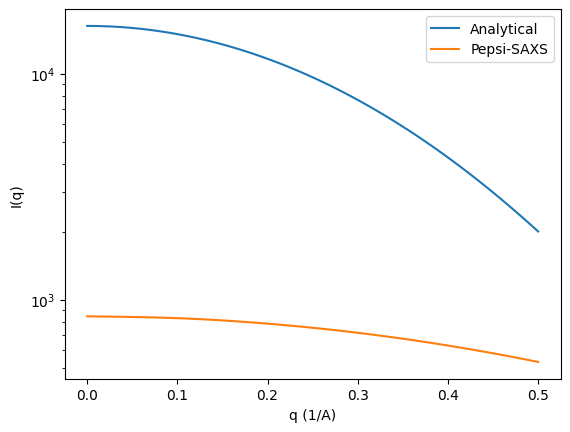

In [27]:
plt.figure()
plt.plot(qrange, Iq_analytical, label='Analytical')
plt.plot(q_pepsi, Iev, label='Pepsi-SAXS')
plt.xlabel('q (1/A)')
plt.ylabel('I(q)')
#plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:

#water_pos = generate_hydration_shell(coordinates, cell_size=5.0, padding=12.0, min_dist=5.0, shell_width=5.0)
qvals, Iqvals = debye.calculate_Iq(xyz_file, poly_coeffs, water_pos)